In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from numpy.fft import fft, ifft
import os

In [27]:
def remove_periodic(X, df_index, detrending=True):
    rad = np.array(X)
    
    if detrending:
        det_rad = rad - np.average(rad)
    else:
        det_rad = rad
    
    det_rad_fft = fft(det_rad)

    # Get the power spectrum
    rad_ps = [np.abs(rd)**2 for rd in det_rad_fft]
    
    frequency_threshold = 0.1e12
    clean_rad_fft = [det_rad_fft[i] if rad_ps[i] > frequency_threshold else 0 
                     for i in range(len(det_rad_fft))]
    
    rad_series_clean = ifft(clean_rad_fft)
    rad_series_clean = [value.real for value in rad_series_clean]
    
    if detrending:
        rad_trends = rad_series_clean + np.average(rad)
    
    rad_clean_ts = pd.Series(rad_trends, index=df_index)
    
    rad_clean_ts[(rad_clean_ts.index.hour < 6) | (rad_clean_ts.index.hour > 20)] = 0
    
    return rad - rad_clean_ts.values, rad_clean_ts.values

In [3]:
os.chdir("/Users/cseveriano/spatio-temporal-forecasting/")

fln_df = pd.read_csv('data/processed/SONDA/FLN-15min.csv', sep=";", parse_dates=['date'], index_col='date')

# Fill the gaps in the series
fln_df = fln_df.fillna(method='ffill')

In [4]:
fln_df = fln_df[(fln_df.index >= '2013-11-01') & (fln_df.index <= '2014-11-01')]

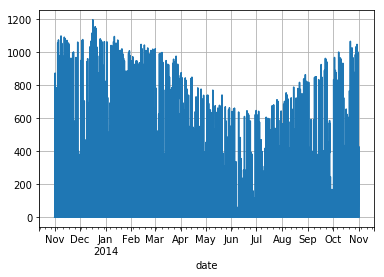

In [5]:
hour_temp = fln_df.resample('H').mean()

hour_temp['glo_avg'].plot()
plt.grid()

In [28]:
fln_residual, fln_clean = remove_periodic(hour_temp['glo_avg'],hour_temp.index)

In [12]:
os.chdir("/Users/cseveriano/spatio-temporal-forecasting/")

joi_df = pd.read_csv('data/processed/SONDA/JOI-15min.csv', sep=";", parse_dates=['date'], index_col='date')

# Fill the gaps in the series
joi_df = joi_df.fillna(method='ffill')
joi_df = joi_df[(joi_df.index >= '2013-11-01') & (joi_df.index <= '2014-11-01')]
joi_hour_temp = joi_df.resample('H').mean()

In [29]:
joi_residual, joi_clean = remove_periodic(joi_hour_temp['glo_avg'],joi_hour_temp.index)

## Cross Correlation Test

In [30]:
np.corrcoef(fln_residual, joi_residual)

array([[ 1.        ,  0.60262961],
       [ 0.60262961,  1.        ]])

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt

nrmse = sqrt(mean_squared_error(hour_temp['glo_avg'], fln_clean)) / np.mean(hour_temp['glo_avg'])

In [34]:
nrmse

0.7791145122036909